In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
plt.style.use('seaborn-white')

In [2]:
directory = '../data/raw/logs/20200526/sustainable_throughput/'

In [4]:
def get_log_files(pattern):
    result = []
    for filename in os.listdir(directory):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, filename))
    return result

In [156]:
def get_kafka_files(pattern):
    result = []
    for filename in os.listdir(directory):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, filename))
    return result

In [152]:
def get_kafka_latency_timeline_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_latency_timeline.csv")
def get_kafka_latency_histogram_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_latency_histogram.csv")
def get_kafka_throughput_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_throughput.csv")

In [153]:
def get_rembrandt_latency_timeline_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_latency_timeline.csv")
def get_rembrandt_latency_histogram_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_latency_histogram.csv")
def get_rembrandt_throughput_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")

In [158]:
def create_kafka_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [63]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [32]:
def plot_histogram(dataframe):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    sns.boxplot(x="Rate Limit in MB/s", y="Throughput in MB/s", data=dataframe, ax=ax)

In [161]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

# Kafka Sustainable Throughput 

In [159]:
kafka_tp_df = create_kafka_dataframe(get_kafka_throughput_files())

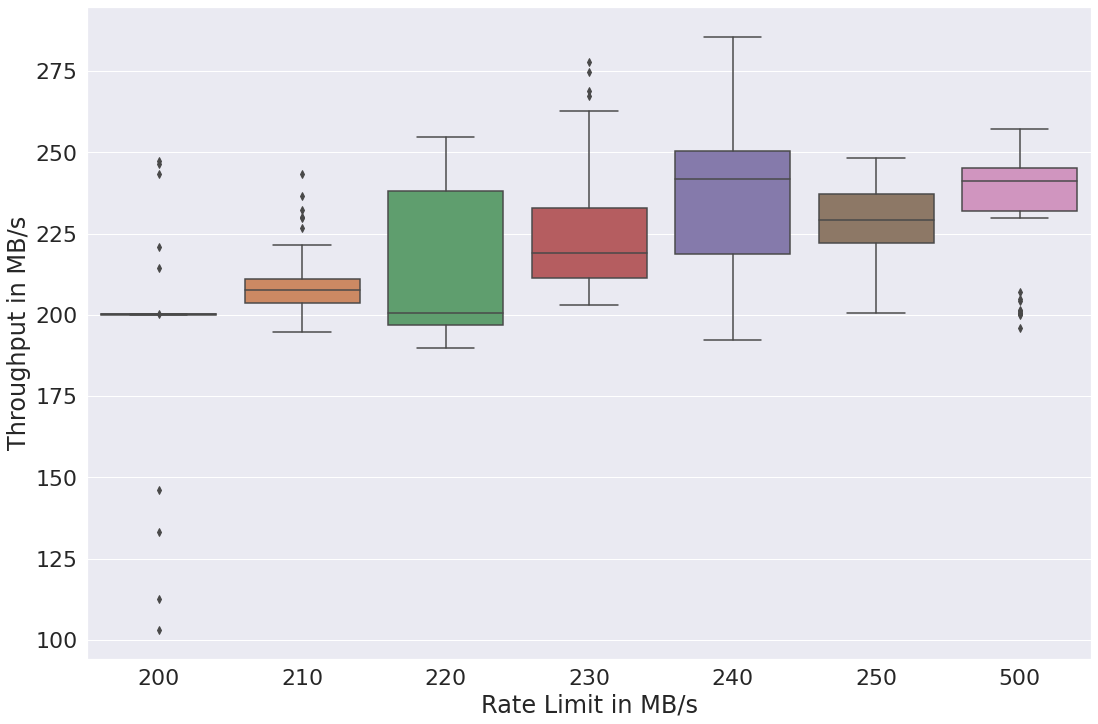

In [160]:
plot_histogram(kafka_tp_df)

In [162]:
kafka_timeline_df = create_kafka_dataframe(get_kafka_latency_timeline_files(), skiprows=2)

In [165]:
kafka_timeline_df.groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean()

Rate Limit in MB/s
200    7.033285e+04
210    7.068981e+04
220    5.543093e+05
230    4.341290e+05
240    5.012645e+05
500    1.952997e+06
Name: Avg. Latency in us, dtype: float64

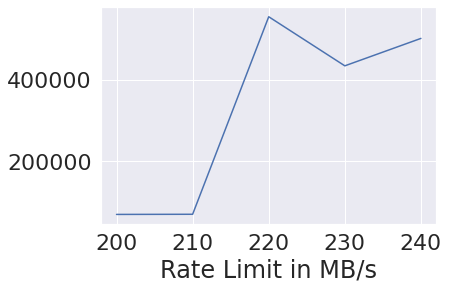

In [168]:
kafka_timeline_df[kafka_timeline_df["Rate Limit in MB/s"] < 300].groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean().plot()

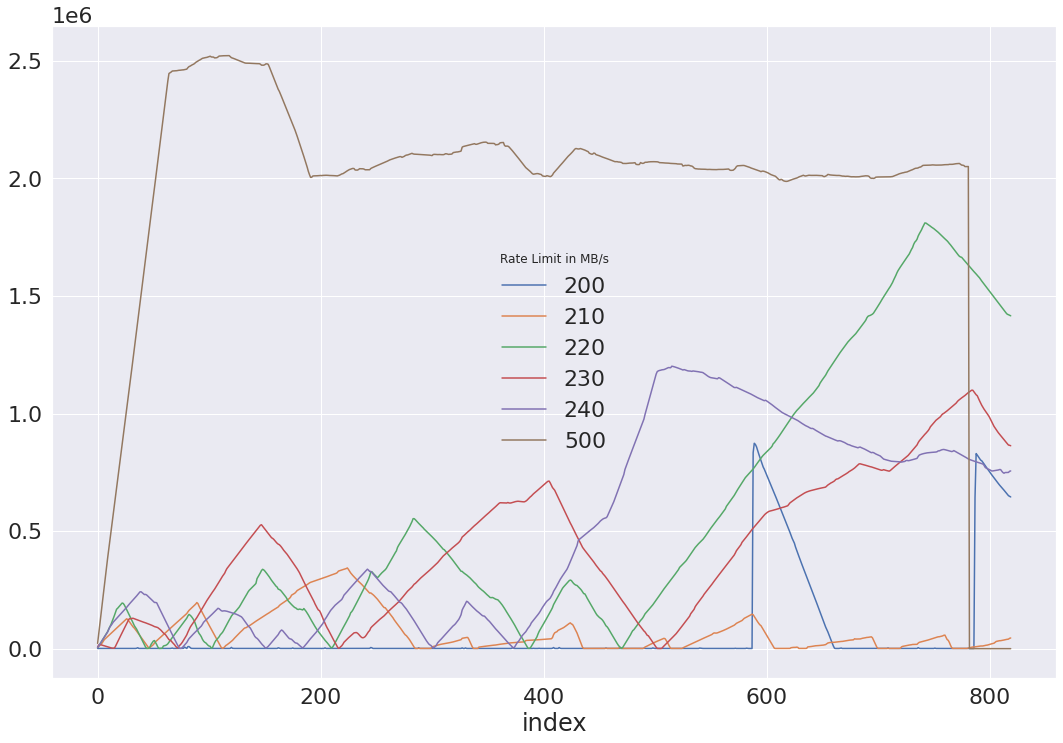

In [169]:
plot_timeseries(kafka_timeline_df, "Avg. Latency in us")

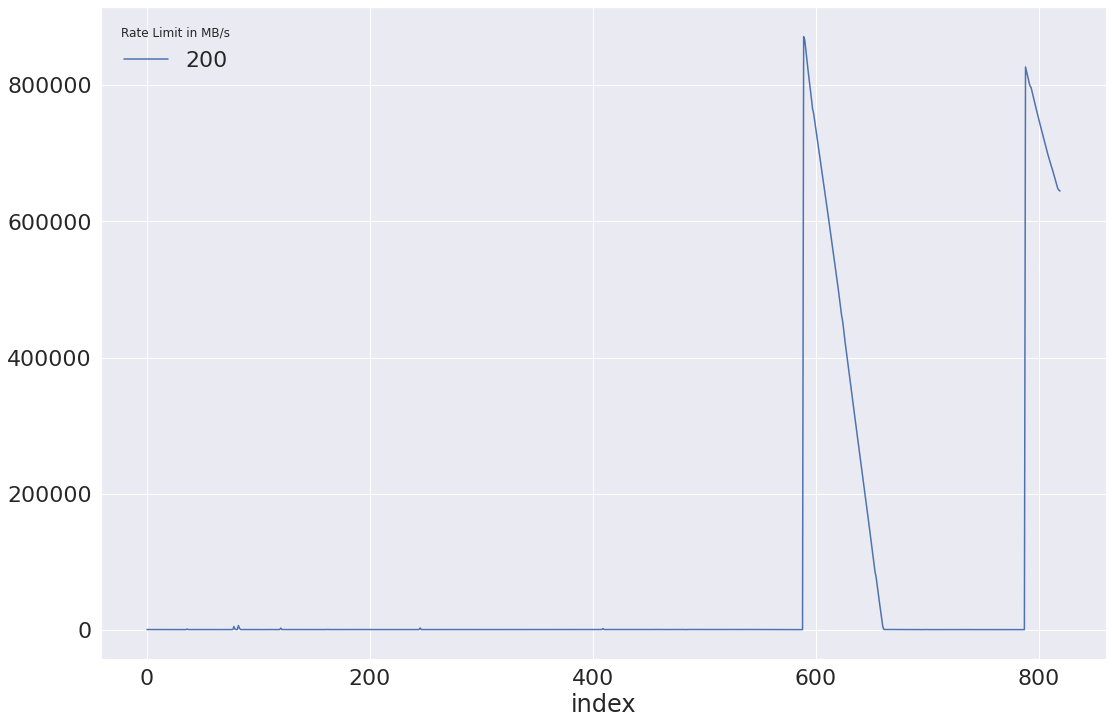

In [176]:
plot_timeseries(kafka_timeline_df[kafka_timeline_df["Rate Limit in MB/s"] == 200], "Min. Latency in us")

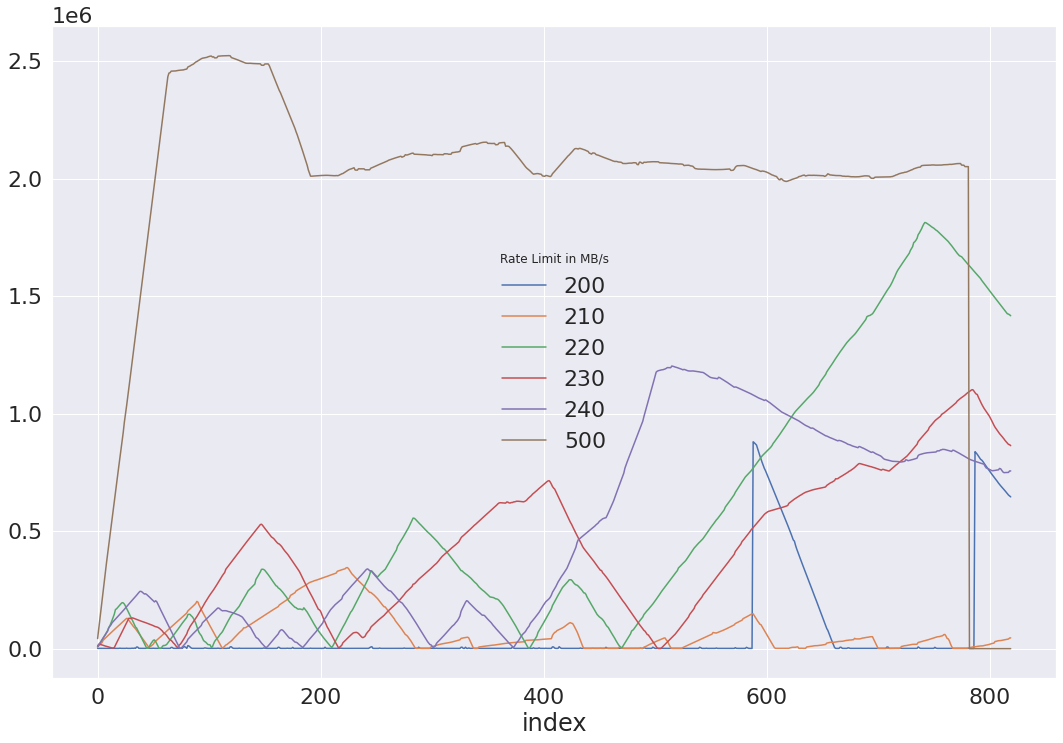

In [171]:
plot_timeseries(kafka_timeline_df, "Max. Latency in us")

# Prototype Sustainable Throughput Analysis

In [64]:
throughput_df = create_dataframe(get_rembrandt_throughput_files())

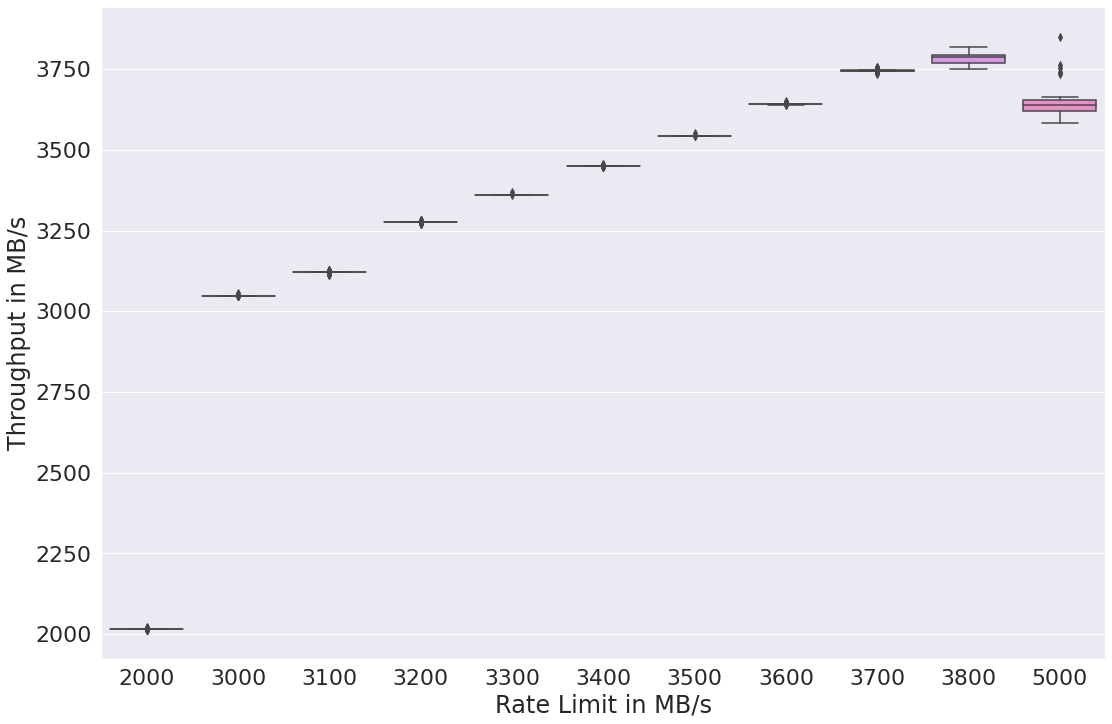

In [66]:
plot_histogram(throughput_df)

In [67]:
timeline_df = create_dataframe(get_rembrandt_latency_timeline_files(), skiprows=2)

In [173]:
timeline_df.groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean()

Rate Limit in MB/s
2000        38.767517
3000        42.583862
3100        41.273096
3200        46.231470
3300        45.485645
3400        47.214673
3500        49.780444
3600        86.792371
3700       512.816797
3800    297189.410327
Name: Avg. Latency in us, dtype: float64

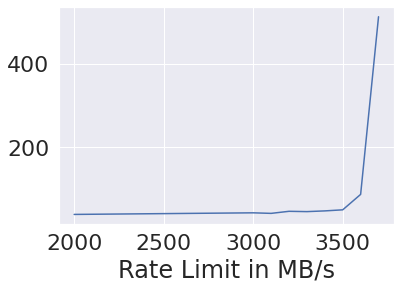

In [174]:
below3800.groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean().plot()

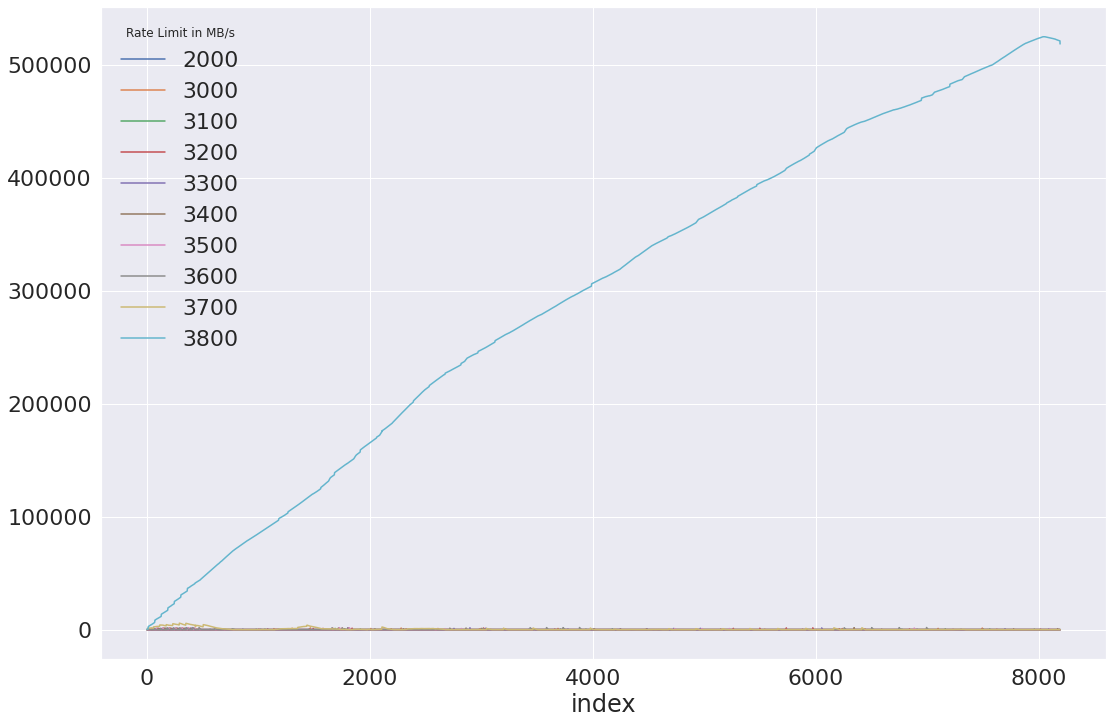

In [141]:
plot_timeseries(timeline_df, "Avg. Latency in us")

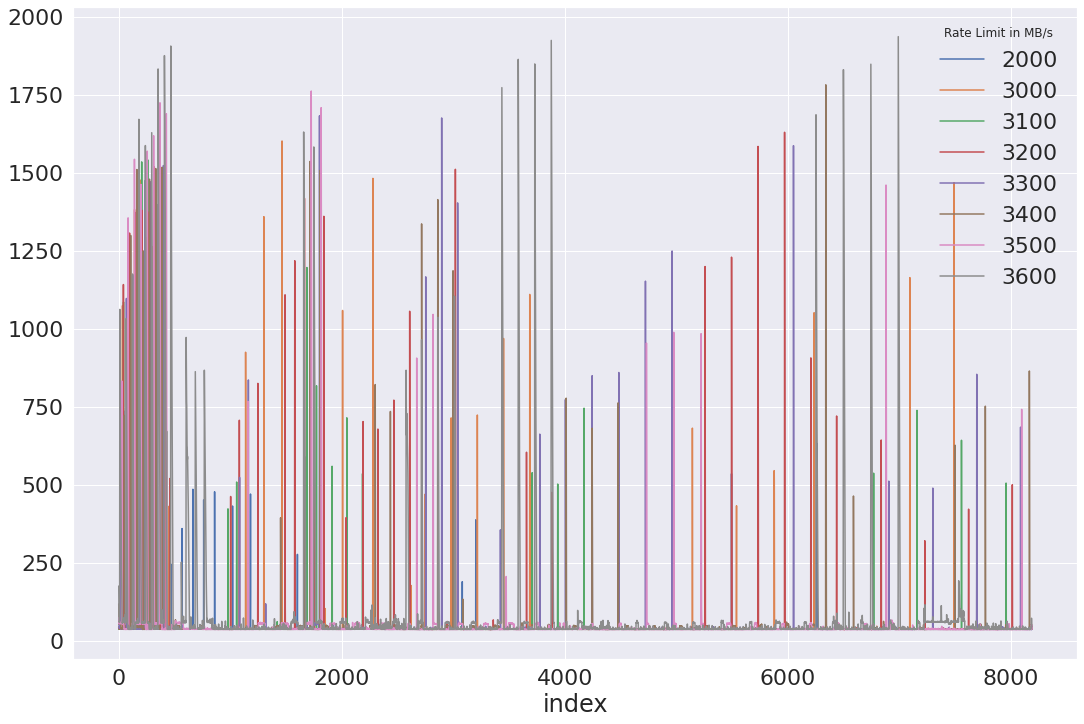

In [177]:
plot_timeseries(timeline_df[timeline_df["Rate Limit in MB/s"] < 3700], "Avg. Latency in us")

In [143]:
below3800 = timeline_df[timeline_df["Rate Limit in MB/s"] < 3800]
filtered = below3800[below3800["Rate Limit in MB/s"] > 3200]

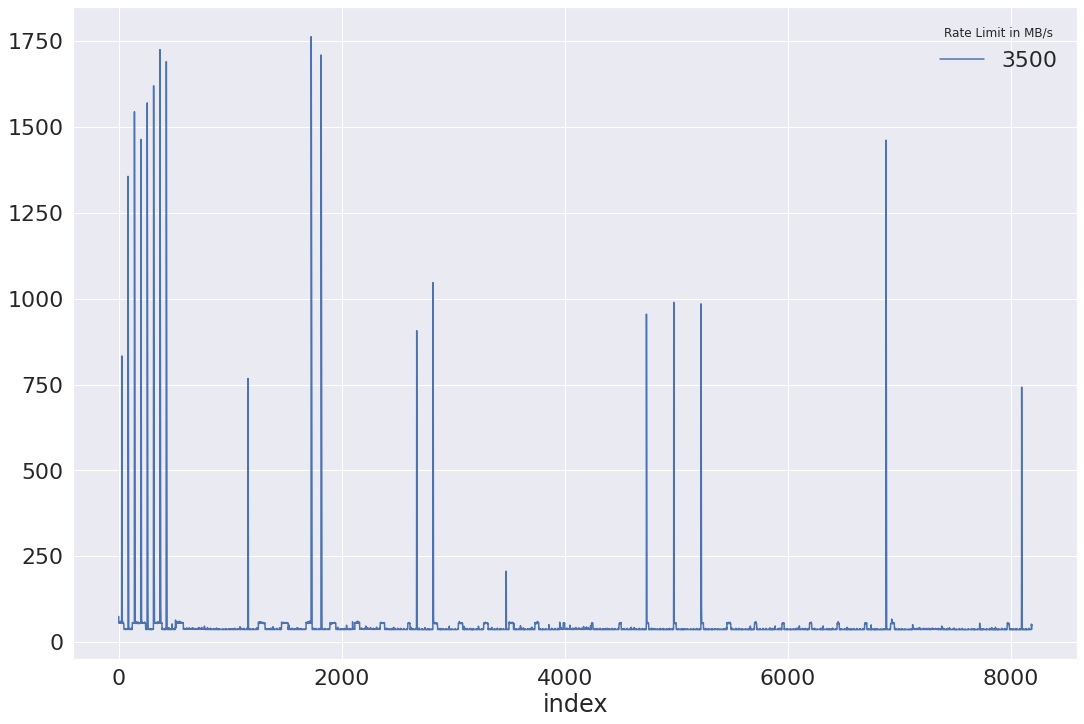

In [175]:
plot_timeseries(timeline_df[timeline_df["Rate Limit in MB/s"] == 3500], "Avg. Latency in us")

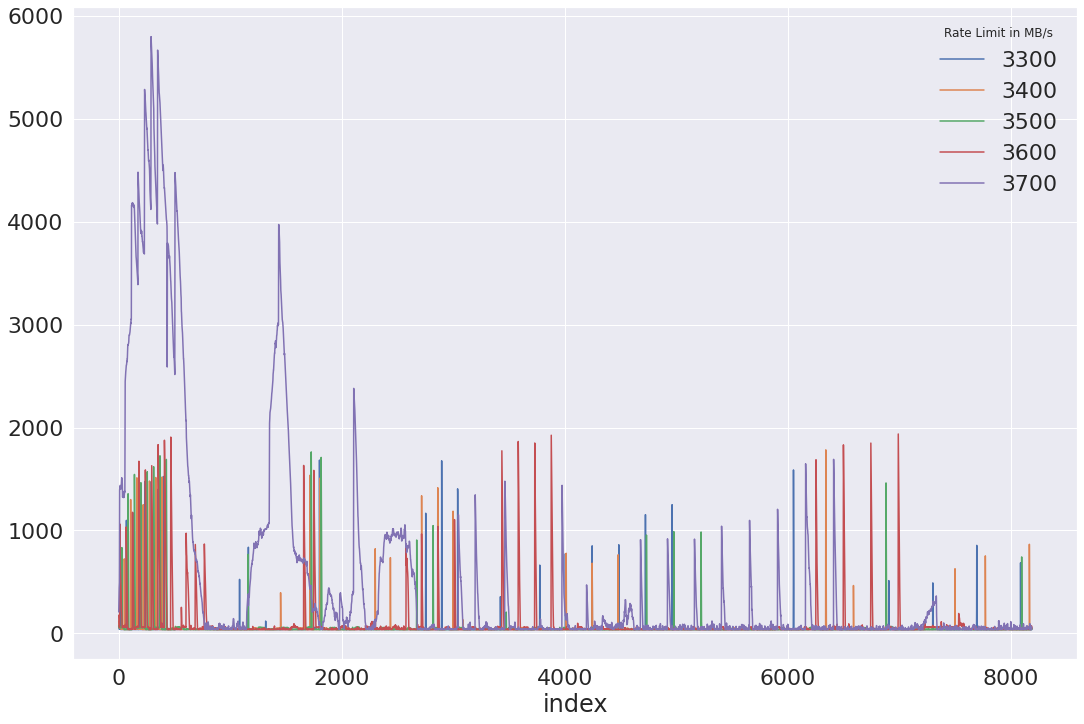

In [145]:
plot_timeseries(filtered, "Avg. Latency in us")

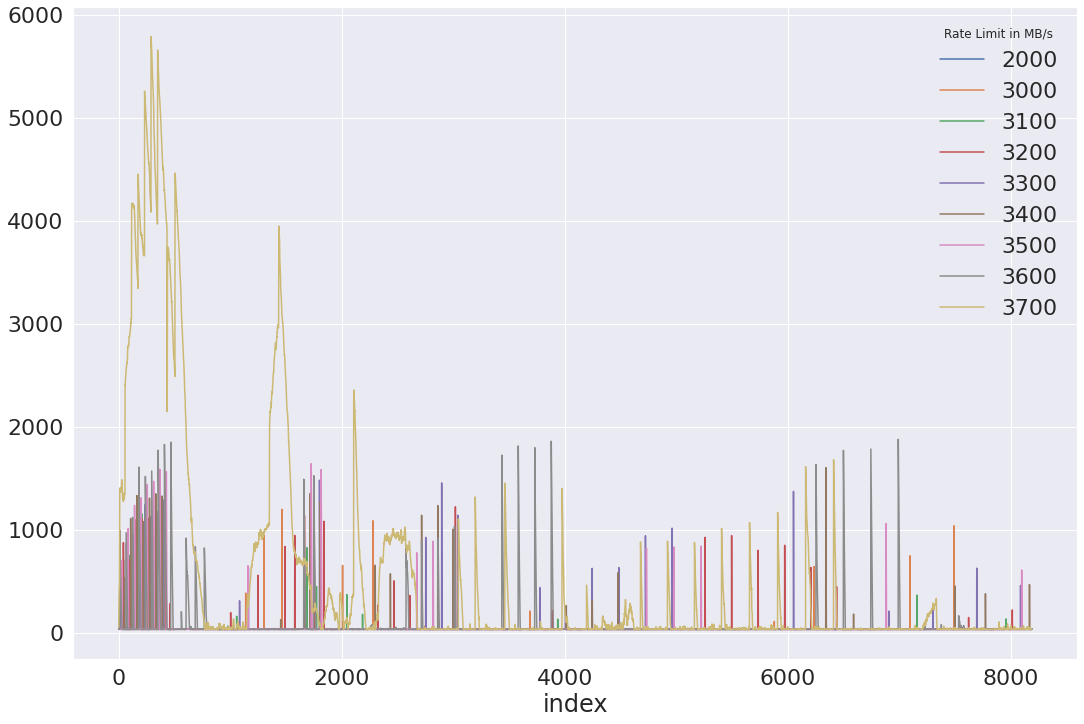

In [146]:
plot_timeseries(below3800, "Min. Latency in us")

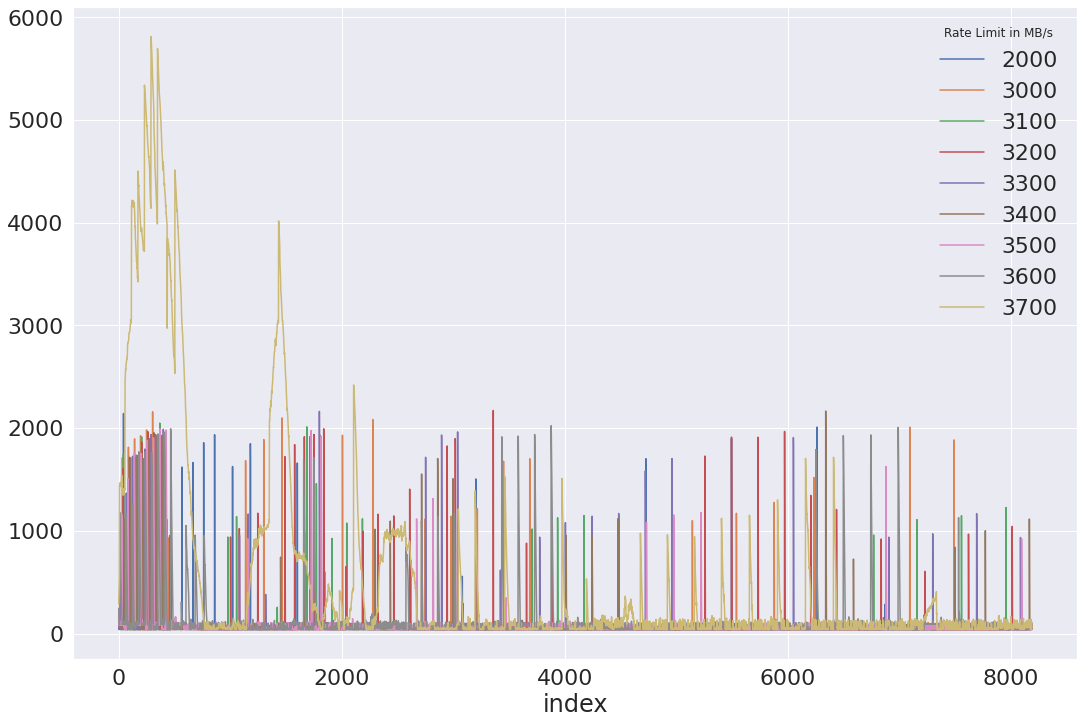

In [147]:
plot_timeseries(below3800, "Max. Latency in us")

--> Use 3.5 for segment count analysis